In [7]:
%config IPCompleter.greedy=True
%config Completer.use_jedi = False

In [8]:
from os.path import join

import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [38]:
d = pd.read_csv(join('_data', 'height.csv'))
d = d[d['age'] >= 18]

### Linear regression

In [39]:
endog = d['height']
exog = sm.add_constant(d['weight'])

mod = sm.OLS(endog, exog)
L = mod.fit()

In [40]:
L.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 height   R-squared:                       0.570
Model:                            OLS   Adj. R-squared:                  0.568
Method:                 Least Squares   F-statistic:                     463.3
Date:                Sun, 13 Jun 2021   Prob (F-statistic):           4.68e-66
Time:                        15:45:54   Log-Likelihood:                -1071.0
No. Observations:                 352   AIC:                             2146.
Df Residuals:                     350   BIC:                             2154.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        113.8794      1.911     59.589      0.000     110.121     117.638
weight         0.9050      0.042     21.524      0.000       0.822       0.988
==============================================================================
Omnibus:                        5.258   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.072   Jarque-Bera (JB):                5.729
Skew:                          -0.180   Prob(JB):                       0.0570
Kurtosis:                       3.511   Cond. No.                         321.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

ValueError: 'color' kwarg must be an color or sequence of color specs.  For a sequence of values to be color-mapped, use the 'c' argument instead.

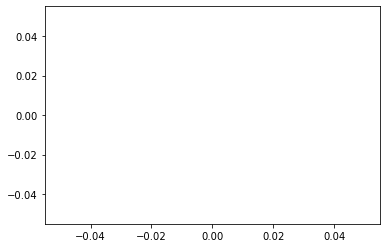

In [65]:
sns.regplot(data=d, x='weight', y='height', ci=None, 
            scatter_kws={'color': 'mutedblue'},
            line_kws={'color': 'r', 'linewidth': 3})
plt.show()